# 고혈압 분석 모델
## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - hyperTension: 고혈압

- 식이패턴 변수

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 불러오기

In [2]:
# 식이패턴과 고혈압의 연관관계 조사
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/year0_NA.csv', index_col=0, na_values=['NA'])
pattern = dataset.reindex(columns=['P1', 'P2', 'P3', 'P4'])
colList = list(pattern.columns)
idx = list(pattern.index)

In [3]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = QuantileTransformer()

X = pd.DataFrame(scaler.fit_transform(pattern), index=idx, columns=colList)
y = dataset['HYPERTENSION']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8733, 4) (971, 4) (8733,) (971,)


## 모델 제작

In [4]:
import IPython
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

!pip install -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 96 kB 2.7 MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=a226f16ed88d8d01130107b79e953a3b137bcd106924f07ecce5dc654c363714
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [5]:
from kerastuner import HyperModel

class RegressionHyperModel(HyperModel):
  def __init__(self, input_shape):
    self.input_shape = input_shape

def model_builder(hp):
  model = Sequential()
  # model.add(Dense(12, input_dim=61, activation='relu'))

  # # Tune the number of units in the first Dense layer
  # # Choose an optimal value between 32-512
  # hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)

  hp_units0 = hp.Int('units_0', min_value = 8, max_value = 128, step = 8)
  hp_units1 = hp.Int('units_1', min_value = 8, max_value = 128, step = 8)
  hp_units2 = hp.Int('units_2', min_value = 8, max_value = 128, step = 8)
  hp_units3 = hp.Int('units_3', min_value = 8, max_value = 128, step = 8)

  model.add(Dense(units = hp_units0,
                  activation='relu',
                  input_shape=input_shape)) # input_dim
        
  model.add(Dense(units = hp_units1,
                  activation='relu'))
  
  model.add(Dropout(hp.Float('dropout_0',
                              min_value=0.0,
                              max_value=0.1,
                              default=0.005,
                              step=0.01)))
  
  model.add(Dense(units = hp_units2,
                  activation='relu'))
  
  model.add(Dense(units = hp_units3,
                  activation='relu'))
        
  model.add(Dropout(hp.Float('dropout_1',
                              min_value=0.0,
                              max_value=0.1,
                              default=0.005,
                              step=0.01)))
        
  model.add(Dense(1, activation='sigmoid')) # 출력층

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                # loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                loss="binary_crossentropy",
                metrics = ['accuracy'])
  # model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
  
  return model

In [15]:
input_shape = (X_train.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 20,
                     factor = 7,
                     directory = '/content/drive/MyDrive/Colab Notebooks',
                     project_name = 'HyperTension_pattern_sh22h') 

In [10]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [16]:
tuner.search(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is
{best_hps.get('units_0'), best_hps.get('units_1'), best_hps.get('units_2'), best_hps.get('units_3')}
and the optimal learning rate for the optimizer is
{best_hps.get('learning_rate')}
drop-out is
{best_hps.get('dropout_0'), best_hps.get('dropout_1')}.
""")

Trial 16 Complete [00h 00m 14s]
val_accuracy: 0.7785787582397461

Best val_accuracy So Far: 0.7785787582397461
Total elapsed time: 00h 02m 10s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is
(64, 112, 80, 8)
and the optimal learning rate for the optimizer is
0.0001
drop-out is
(0.08, 0.08).



In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), verbose=0)
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

31/31 [==============================] - 0s 1ms/step - loss: 0.5410 - accuracy: 0.7765
accuracy: 77.65%


[Text(0, 0.5, 'loss'), Text(0.5, 0, 'epoch'), Text(0.5, 1.0, 'model loss')]

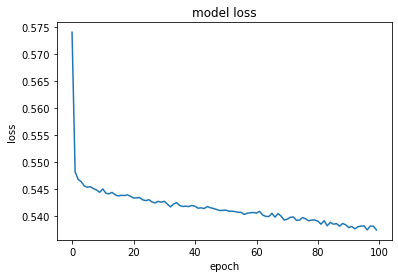

In [ ]:
fig, ax1 = plt.subplots()

# 모델의 오차를 그립니다.
ax1.plot(history.history['loss'])
ax1.set(title='model loss', xlabel='epoch', ylabel='loss')

## Decision Tree

### 하이퍼 파라미터

- min_samples_split
  - 노드를 분할하기 위한 최소한의 샘플 데이터 수로 과적합 제어에 사용.
  - default는 2이다. 작게 설정할수록 분할되는 노드가 많아져 과적합 가능성 증가.
- min_samples_leaf
  - 말단 노드가 되기위한 최소한의 샘플 수
  - 과적합 제어 용도. 비대칭적 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있어 이 경우에는 작게 설정.
- max_features
  - 최적의 분할을 위해 고려할 최대 feature 개수. default는 None으로 데이터 세트의 모든 feature을 사용하여 분할.
  - int로 지정 시 대상 feature 개수, float로 지정 시 전체 feature중 대상 feature의 퍼센트
  - sqrt는 전체 feature중 제곱근 값.
  - auto는 sqrt와 동일
  - log는 전체 featur을 log2()로 선정
- max_depth
  - 트리의 최대 깊이 지정
  - default는 None. 이는 완벽히 클래스 결정값이 될때 까지 깊이를 계속 키우거나 노드가 가지는 데이터 개수가 min_samples_split보다 작아질 때 까지 계속 분할
  - 깊이가 깊어지면 min_samples_split 설정대로 최대 분할하여 과적합할 수 있으므로 적당한 값으로 제어.
- max_leaf_nodes
  - 말단 노드 최대 개수

- 출처: https://velog.io/@lsmmay322/%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%ACDecision-Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

pattern_tree = DecisionTreeClassifier(max_depth=3,
                                      min_samples_leaf=4,
                                      random_state=123)
pattern_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(pattern_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(pattern_tree.score(X_test, y_test)))

importances = pattern_tree.feature_importances_
print("특성 중요도:\n{}".format(importances))

훈련 세트 정확도: 0.763
테스트 세트 정확도: 0.779
특성 중요도:
[0.07808644 0.         0.2789306  0.64298296]


Text(0, 0.5, 'feature importance')

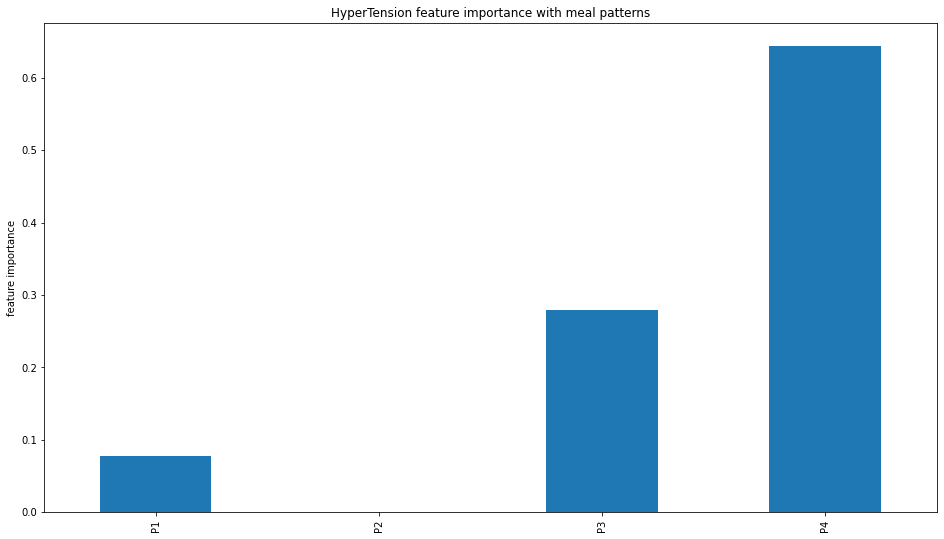

In [ ]:
# 특성 중요도 그래프

tree_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots(figsize=(16, 9))
tree_importances.plot.bar(ax=ax)
ax.set_title("HyperTension feature importance with meal patterns")
ax.set_ylabel("feature importance")

In [ ]:
export_graphviz(ht_tree, out_file="tree.dot",
                class_names='FT',
                feature_names=X.columns,
                impurity=True, filled=True)

In [ ]:
!ls

drive  sample_data  tree.dot


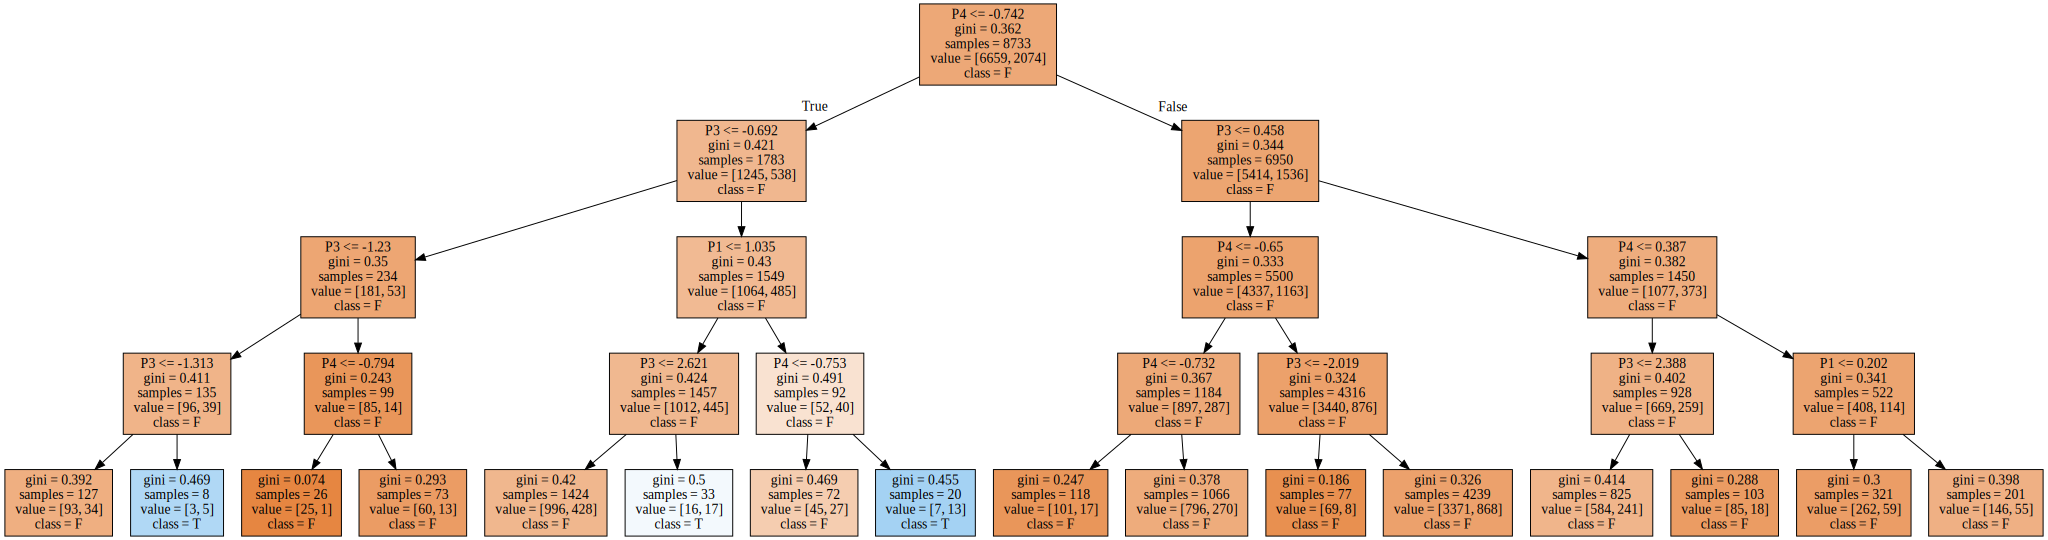

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph, filename='tree.png',format='png')

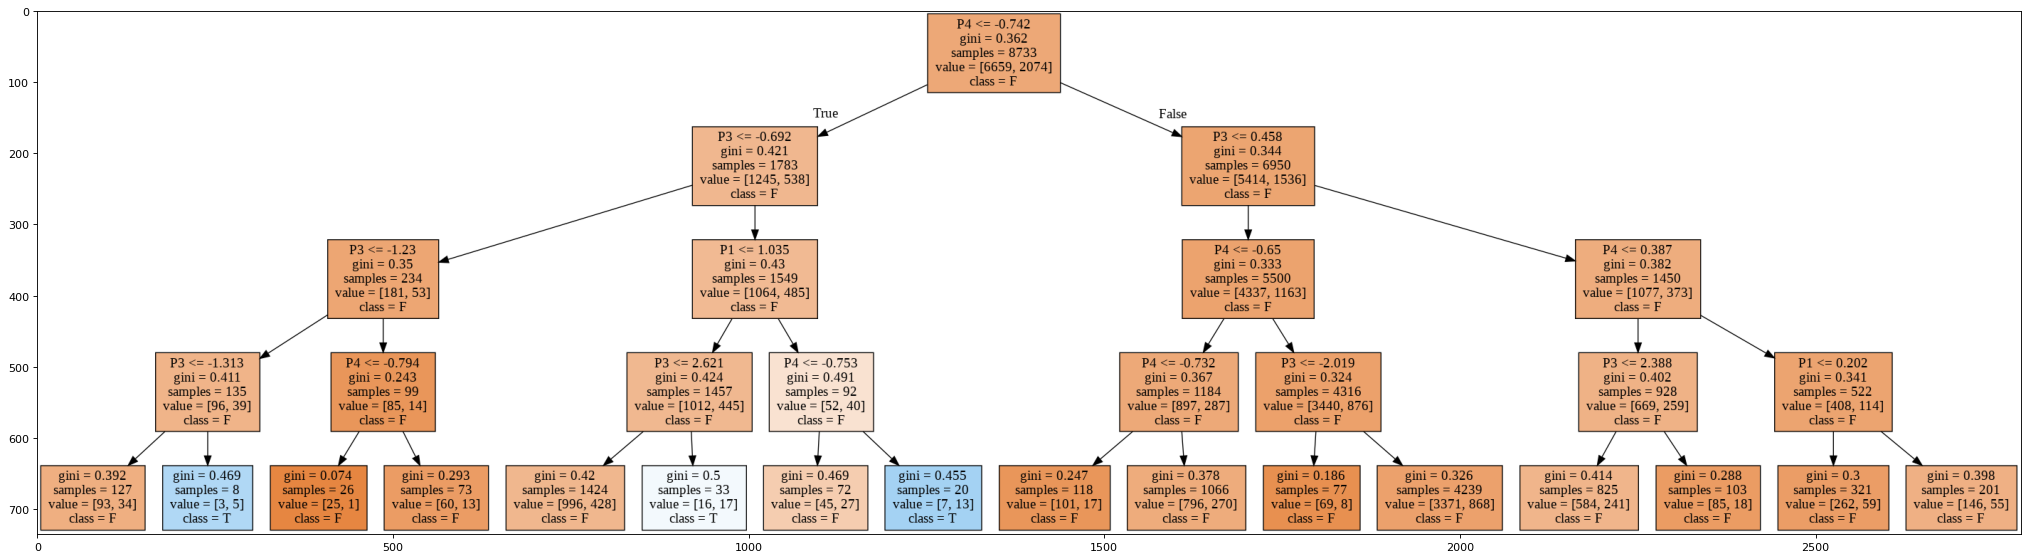

In [ ]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)